In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, ConfusionMatrixDisplay)
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('telco_cleaned.csv')
print(df.shape)
df.head()

(7032, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [19]:
X = df.drop("Churn", axis=1)
y = df["Churn"]
X.shape
y.value_counts(0)

Churn
0    5163
1    1869
Name: count, dtype: int64

In [20]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]
categorical_features = [col for col in X.columns if col not in numeric_features]

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(y_train.mean(), y_test.mean())  # should both be ~0.27

0.2657777777777778 0.2658137882018479


In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ]
)

In [23]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ),
    
    "XGBoost": XGBClassifier(
        random_state=42,
        scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
        eval_metric="logloss"
    )
}


Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC-AUC: 0.8353130128228357


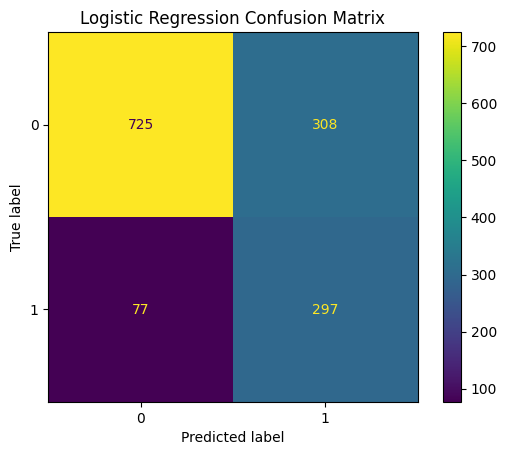


Random Forest
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.62      0.47      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC-AUC: 0.8178000320959151


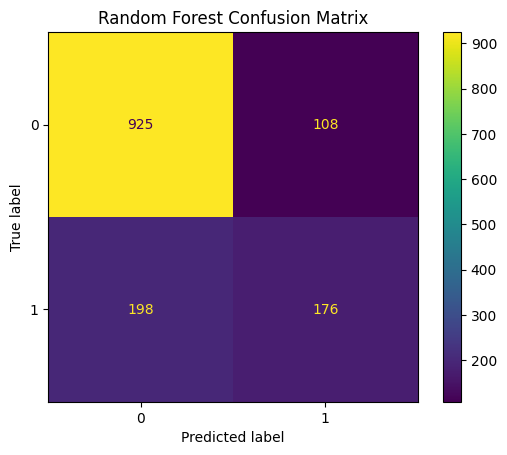


XGBoost
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1033
           1       0.53      0.68      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407

ROC-AUC: 0.8146292662977362


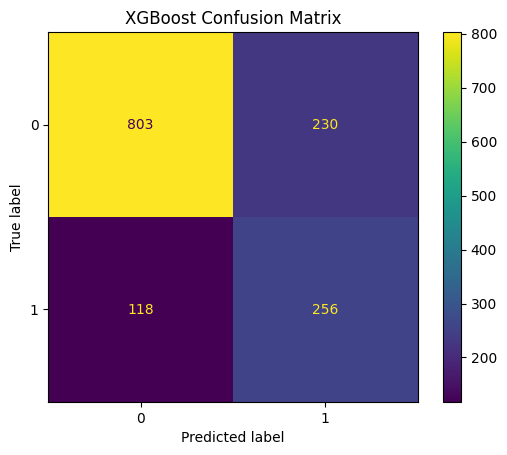

In [24]:
results = []

for name, model in models.items():
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)
    
    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })
    
    print("\n=========================")
    print(name)
    print("=========================")
    print(classification_report(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, probs))

    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [25]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Recall", ascending=False)

,Model,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.490909,0.794118,0.606742,0.835313
2,XGBoost,0.526749,0.684492,0.595349,0.814629
1,Random Forest,0.619718,0.470588,0.534954,0.817800


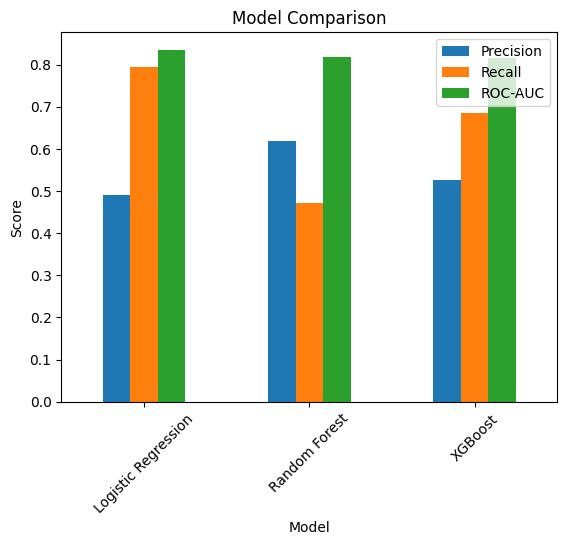

In [26]:
results_df.plot(x="Model", y=["Precision", "Recall", "ROC-AUC"], kind="bar")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [27]:
############## so we know that logistic regression is the best model to go with here

logistic_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logistic_pipe.fit(X_train, y_train)

logistic_probs = logistic_pipe.predict_proba(X_test)[:, 1]

In [28]:
thresholds = np.arange(0.3, 0.7, 0.05)

for t in thresholds:
    preds = (logistic_probs >= t).astype(int)
    print(f"Threshold: {t:.2f}")
    print("Recall:", recall_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("----------------------")

Threshold: 0.30
Recall: 0.9278074866310161
Precision: 0.41408114558472553
----------------------
Threshold: 0.35
Recall: 0.9037433155080213
Precision: 0.4300254452926209
----------------------
Threshold: 0.40
Recall: 0.8716577540106952
Precision: 0.4527777777777778
----------------------
Threshold: 0.45
Recall: 0.8315508021390374
Precision: 0.47192716236722304
----------------------
Threshold: 0.50
Recall: 0.7941176470588235
Precision: 0.4909090909090909
----------------------
Threshold: 0.55
Recall: 0.7620320855614974
Precision: 0.515370705244123
----------------------
Threshold: 0.60
Recall: 0.7192513368983957
Precision: 0.5445344129554656
----------------------
Threshold: 0.65
Recall: 0.679144385026738
Precision: 0.5746606334841629
----------------------


In [29]:
##### the threshold=0.4 is the best tradeoff in recall and precision

probs = logistic_pipe.predict_proba(X_test)[:, 1]

threshold = 0.40
preds = (probs >= threshold).astype(int)

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1033
           1       0.45      0.87      0.60       374

    accuracy                           0.69      1407
   macro avg       0.69      0.75      0.67      1407
weighted avg       0.80      0.69      0.70      1407



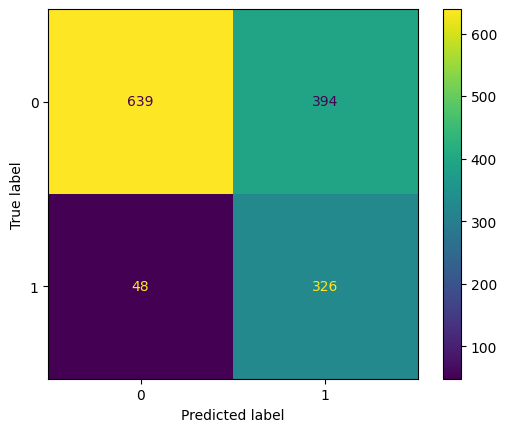

In [30]:
print(classification_report(y_test, preds))

ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

In [31]:
import joblib

joblib.dump(logistic_pipe, "churn_model.pkl")

['churn_model.pkl']